In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import convolve, signal, fftpack, fft
import IPython.display as ipd

In [62]:
plt.style.use(['Solarize_Light2', 'seaborn-talk'])
cmap = plt.cm.spring

A filter kernel is the impulse response of a filter. If you have this information, you can convolve
the filter kernel with any signal to apply the spectral response of the filter to that signal.
This is true because convolution in the time domain is multiplication in the frequency domain.

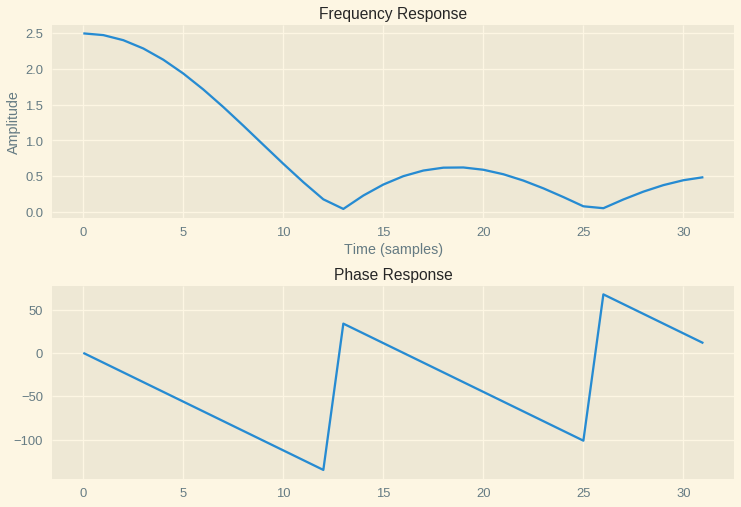

In [14]:
# Here are some coefficients for an FIR filter. We could create a function to
# apply this filter to a signal, then apply it to an impulse to capture the 
# impulse response. There's no need to, however, because for any FIR filter,
# the coefficients *are* the impulse response.

f_coeffs = [0.5,0.5,0.5,0.5,0.5]
t = np.arange(0,1,1/64)

nf = len(f_coeffs)

N = 64

# Pad the impulse response with zeros until its length = 64 samples,
# so that we can apply a 64-point fft to it. Keep in mind that this
# adds no new information to the impulse response.
padded_coeffs = np.concatenate([f_coeffs, np.zeros(N - nf)])

fft_coeffs = fftpack.fft(padded_coeffs)

fig, (ax1, ax2) = plt.subplots(2)

# Note that we aren't yet normalizing the amplitude of the output.
ax1.set_title('Frequency Response')
ax1.set_xlabel('Time (samples)')
ax1.set_ylabel('Amplitude')
ax1.plot(np.abs(fft_coeffs[:N//2]))

ax2.set_title('Phase Response')
ax2.plot(np.angle(fft_coeffs[:N//2],deg=True))

fig.tight_layout()

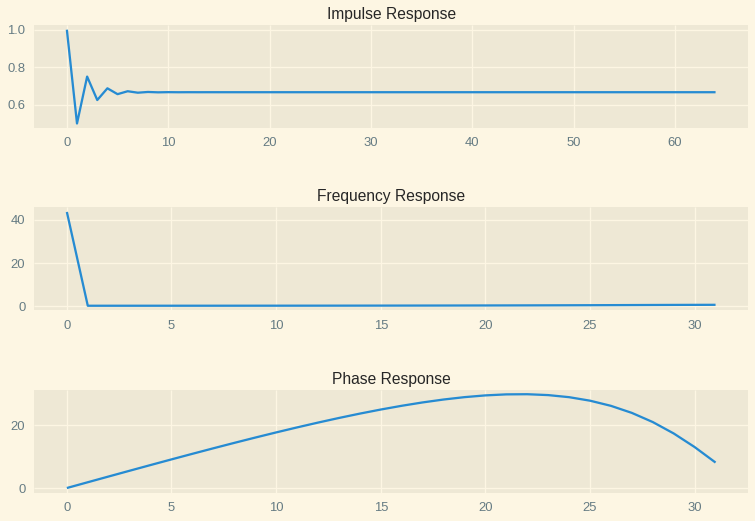

In [15]:
f_coeffs = [0.5,0.5]

def iir_filter(input, f_coeffs):
    N = len(input)
    buffer = np.zeros(N)
    output = np.zeros(N)
    for i in range(N):
        output[i] = input[i]
        for j in range(len(f_coeffs)):
            output[i] += buffer[j] * f_coeffs[j]
        buffer = np.concatenate([[output[i]],buffer[:-1]])
    return output

impulse = np.concatenate([np.ones(1), np.zeros(64)])

impulse_response = iir_filter(impulse, f_coeffs)
N = len(impulse_response)

fig, (ax1, ax2, ax3) = plt.subplots(3)

# Let's see what the impulse response looks like
ax1.set_title('Impulse Response')
ax1.plot(impulse_response)

# Note that we're not
fft_coeffs = fftpack.fft(impulse_response)
ax2.set_title('Frequency Response')
ax2.plot(np.abs(fft_coeffs[:N//2]))

ax3.set_title('Phase Response')
ax3.plot(np.angle(fft_coeffs[:N//2],deg=True))

fig.tight_layout(pad=0.4,h_pad=4.0)

/home/kwaddle/Jupyter_Notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/kwaddle/Jupyter_Notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


<StemContainer object of 3 artists>

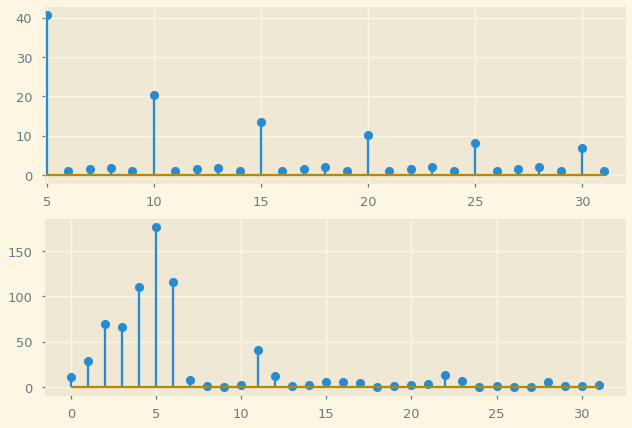

In [6]:
# So does the impulse response of our iir filter work as advertised?

# Try designing a filter in the cell above and add the coefficients here.
f_coeffs=[0.5,0.5]

impulse_response = iir_filter(impulse, f_coeffs)

sr = 128
f = 5
t = np.arange(0.,1.,1/sr)

sig = signal.sawtooth(2*np.pi*f*t)

sig_coeffs = fftpack.fft(sig)

flt_sig = convolve(sig, impulse_response[:16])

f_sig_coeffs = fftpack.fft(flt_sig)

fig, (ax1, ax2) = plt.subplots(2)
ax1.set_xlim(4.9, len(sig_coeffs[:N//2]))
ax1.stem(np.abs(sig_coeffs[:N//2]))

ax2.stem(np.abs(f_sig_coeffs[:N//2]))

# It does seem to work!

Let's create our own filter kernel! To do this we can just create an ideal frequency window in
the frequency domain, and then use the IDFT to get something we can convolve with any signal in
the time domain to do the filtering.

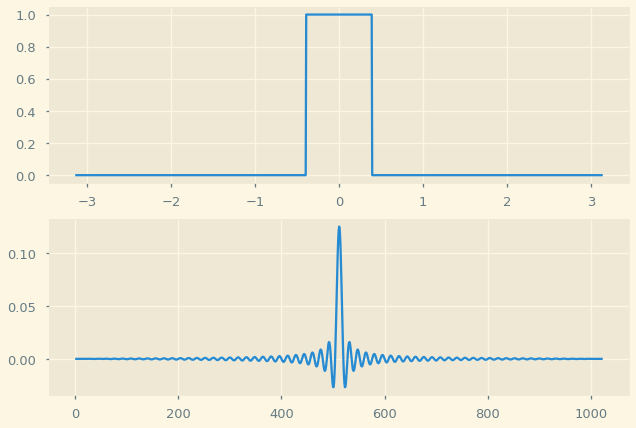

In [306]:
N = 1024
t = np.linspace(0, 2*np.pi, N)
shift_t = np.linspace(-np.pi, np.pi, N)
window = signal.square(t + np.pi / 8, duty=(1/8)) * 0.5 + 0.5

# The fft yields a list of complex numbers. What does the ifft yield?
kernel = fft.fftshift(fft.ifft(window))

fig, (ax1, ax2) = plt.subplots(2)

# Use fftshift to place 0 rad in center for plotting
ax1.plot(shift_t, fft.fftshift(window))
ax2.plot(kernel)

Since the kernel is theoretically infinite, we can think of it as being windowed by a rectangular
window that is the size of the kernel. We can make that window smaller by using less of the kernel,
and that will cause the frequency response of our kernel to be less ideal.

/home/kwaddle/Jupyter_Notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


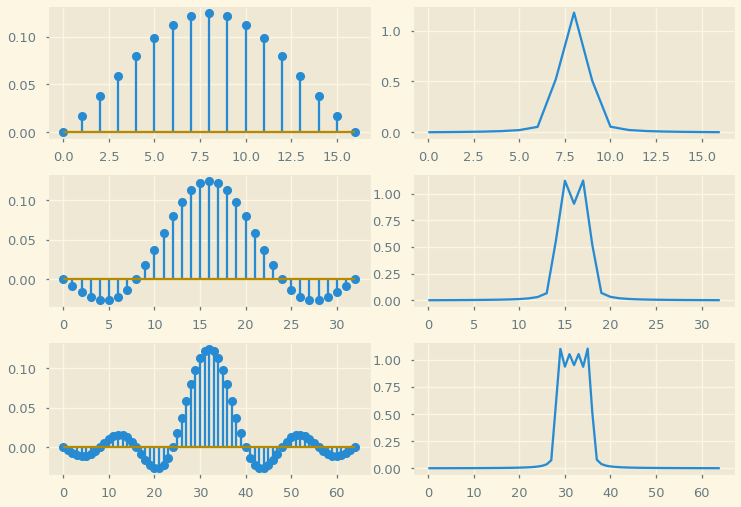

In [307]:
midpoint = len(kernel) // 2
fig, ax = plt.subplots(3, 2)

# Examine the fidelity of different sized slices of the kernel.
for i, size in enumerate([17, 33, 65]):
    k = kernel[midpoint - size // 2: midpoint + size // 2 + 1]
    freqs = np.abs(fft.fft(k))
    ax[i, 0].stem(k)
    ax[i, 1].plot(fft.fftshift(freqs))

fig.tight_layout()

The filter kernel is ready to be convolved with an input signal.

**Convolution in the time domain is multiplication in the frequency domain**

So convolving our kernel with an input signal will map the spectral characteristics we
see above onto our input signal.

Another thing to remember is that when using FIR filter designs, **the filter kernel
is its impulse response.**

We can listen to a basic sawtooth wave before and after convolution with the filter
kernel and hear that higher frequencies are less present in the signal after convolution

(0, 2000)

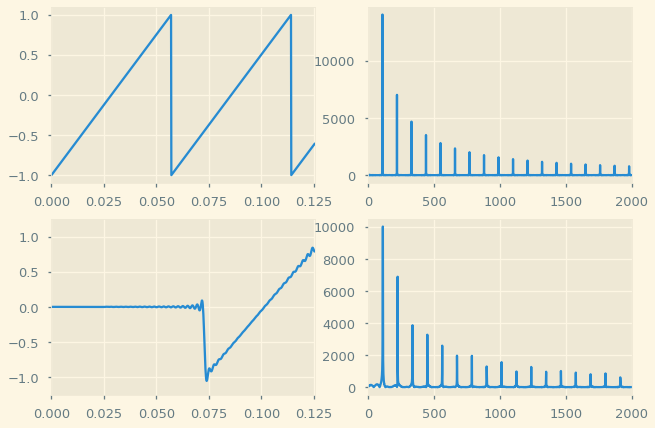

In [308]:
sample_rate = 44100
freq = 110
t = np.linspace(0, 2*np.pi, sample_rate)
sig = signal.sawtooth(freq * t)
filtered_sig = signal.convolve(sig, kernel)
ipd.Audio(data=sig, rate=sample_rate, autoplay=False)

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(t, sig)
ax[0, 0].set_xlim([0, np.pi / 25])
ax[0, 1].plot(np.abs(fft.fft(sig)))
ax[0, 1].set_xlim([0, 2000])
ax[1, 0].plot(t, filtered_sig[0: len(t)])
ax[1, 0].set_xlim([0, np.pi / 25])
ax[1, 1].plot(np.abs(fft.fft(filtered_sig)))
ax[1, 1].set_xlim([0, 2000])

In [309]:
ipd.Audio(data=sig, rate=44100, autoplay=False)

In [310]:
ipd.Audio(data=filtered_sig, rate=44100, autoplay=False)